In [1]:
import pickle
import numpy as np
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

## Read in Embeddings and Word Dictionary

In [2]:
mus = np.load('final-pass/mu.npy')
logsigmas = np.load('final-pass/sigma.npy')
word_dictionary = pickle.load(open('final-pass/word2id.pkl', 'rb'), encoding='latin1')

# Decode from bytes
word_dictionary = {key: value for key, value in word_dictionary.items()}
reversed_word_dictionary = {value: key for key, value in word_dictionary.items()}

In [3]:
print('Shape of mus: {}'.format(mus.shape))
print('Shape of logsigmas: {}'.format(logsigmas.shape))
print('Vocabulary size: {}'.format(len(word_dictionary)))

Shape of mus: (716591, 4, 50)
Shape of logsigmas: (716591, 4, 1)
Vocabulary size: 716591


In [4]:
# Sanity check
assert not (np.isnan(mus).any() or np.isnan(logsigmas).any())

## Check similarity of words

In [5]:
def el_similarity(mu1, mu2, sigma1, sigma2):
    foo = np.log((sigma1 + sigma2) ** 50)
    bar = 50 * np.log(2*np.pi)
    baz = np.sum((mu1 - mu2) ** 2 / (sigma1 + sigma2))
    return -0.5 * (foo + bar + baz)

In [6]:
word = 'rock'
idx = word_dictionary[word]

In [7]:
mus_ = mus[idx]
sigmas_ = np.exp(logsigmas[idx]).flatten()
[(i, j, el_similarity(mus_[i], mus_[j], sigmas_[i], sigmas_[j])) for j in range(4) for i in range(j)]

[(0, 1, 6.667912102649936),
 (0, 2, 4.978960678460702),
 (1, 2, 7.2015156141835845),
 (0, 3, 5.255042240192374),
 (1, 3, 6.650645002750551),
 (2, 3, 9.581723847237512)]

## Simulate Similarities

In [15]:
from matplotlib import rc

rc('font', **{'family':'serif', 'serif':['DejaVu Sans']})
rc('text', usetex=True)

In [16]:
N = 1000
mu_rand1 = np.random.uniform(-1, 1, N)
mu_rand2 = np.random.uniform(-1, 1, N)
sigma_rand1 = 0.05
sigma_rand2 = 0.05

x = [el_similarity(mu_rand1[i], mu_rand2[j], sigma_rand1, sigma_rand2) for i in range(N) for j in range(N)]

/Users/george/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


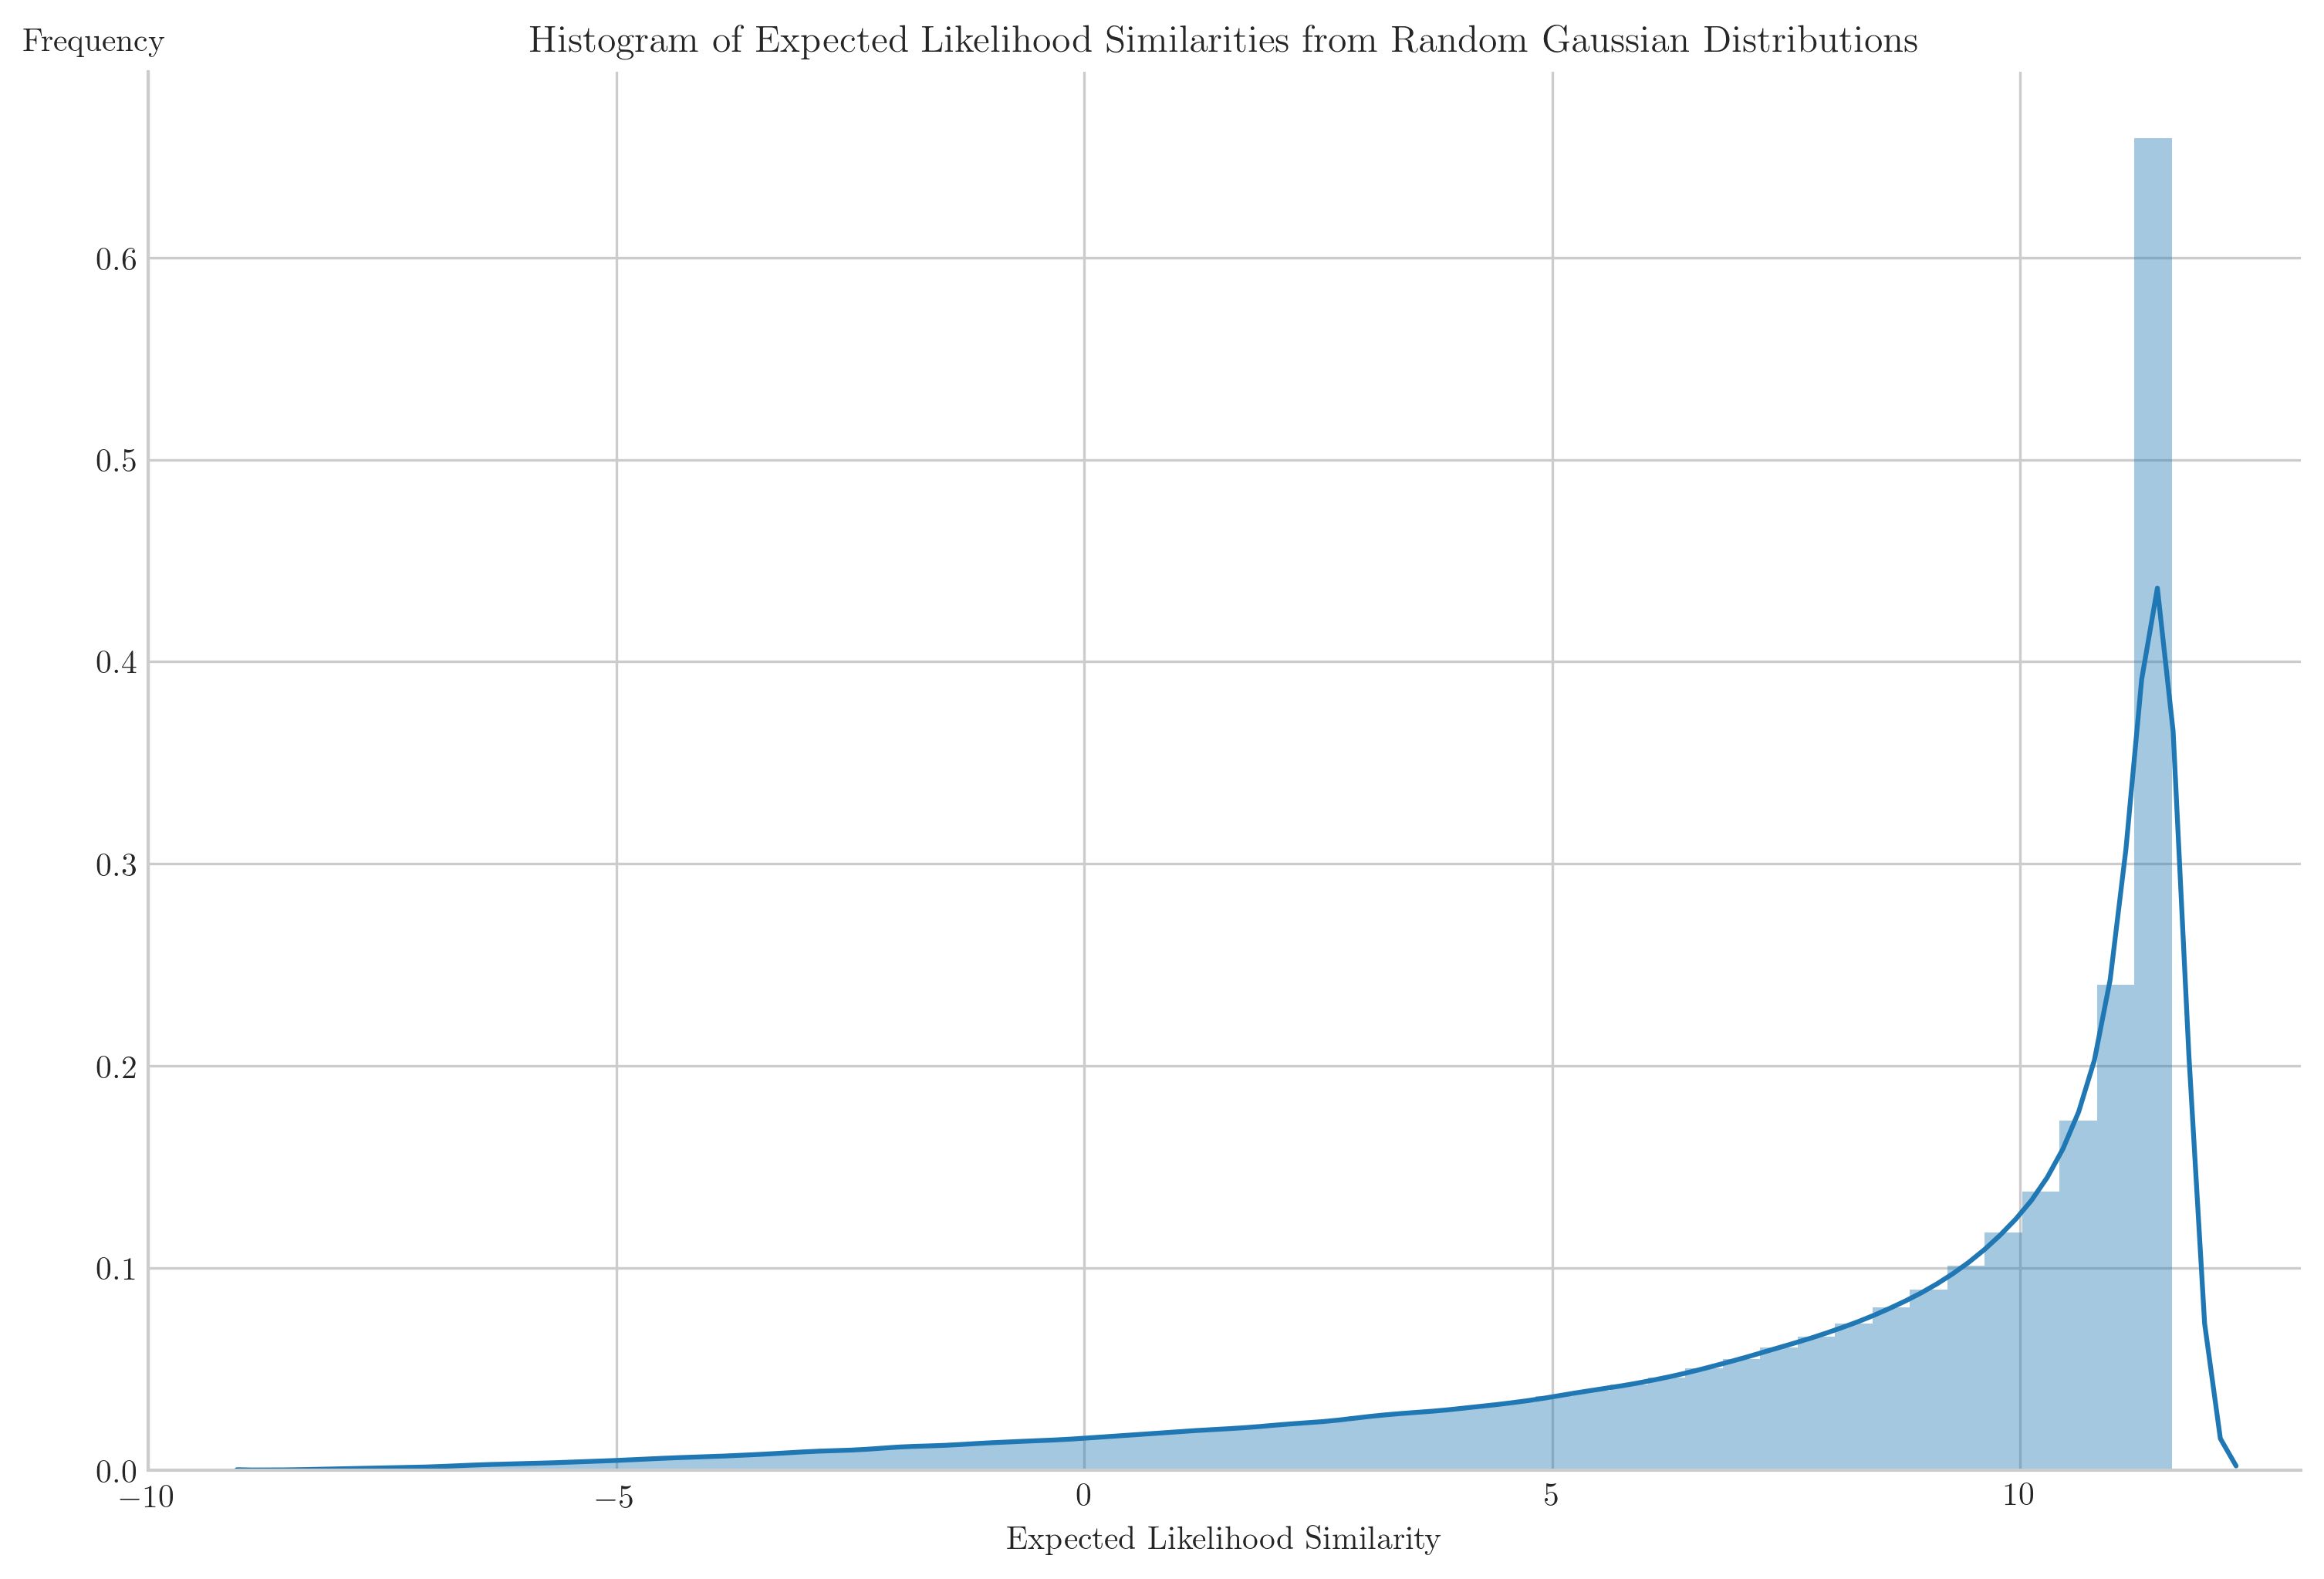

In [28]:
plt.figure(figsize=[12, 8], dpi=300)
sns.distplot(x)
sns.despine()

plt.xlim(-10, 13)

ax = plt.gca()
ax.set_title('Histogram of Expected Likelihood Similarities from Random Gaussian Distributions')
ax.set_xlabel('Expected Likelihood Similarity')

h = ax.set_ylabel('Frequency')
h.set_rotation(0)
ax.yaxis.set_label_coords(-0.025, 1.01)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

## kNN Analysis

In [8]:
knn = NearestNeighbors(n_neighbors=10).fit(mus.reshape(-1, 50, order='F'))  # It's important that order='F'!

In [9]:
words = ['rock', 'bank', 'apple', 'star', 'cell', 'left',
         'tank', 'board', 'record', 'lie', 'right', 'chair', 'bar', 'lead']

for word in words:
    idx = word_dictionary[word]
    embedding = mus[idx]
    for i in range(4):
        indices = knn.kneighbors(embedding[i].reshape(1, -1), return_distance=False)
        foo = [np.exp(logsigmas.flatten(order='F')[j]) for j in indices.flatten()]
        bar = [reversed_word_dictionary[j % len(reversed_word_dictionary)] for j in indices.flatten()]
        lst = [x for _, x in sorted(zip(foo[1:], bar[1:]))]
        print(bar[0] + '\t' + ' '.join(lst))

rock	caldera rocks limestone petrified summit range. rock. slope mountain
rock	enon rocks rocky smooth hard california up well known
rock	reggae punk rb selftitled albums. rock. pop bands rock
rock	reggae punk thrash albums. rock. bands soul bands rock
bank	stretch edge northwest hill side east across point just
bank	bank. renaming branches bank capital. renamed central its it
bank	assets. asset investor securities shareholders banking investment banks holding
bank	banco banking bank. invested sterling branches banks bank branch
apple	iwork macintosh developers portable developer machine. standalone project run
apple	iphone microsoft os2 treo apple apples shipped xen package
apple	flavors apple onions apples vanilla peanut apples honey chips
apple	rockpile hecky thornley ebel wasnt 0for4 winds recalls decided
star	enckelman femi blue three took time one this a
star	star. nebula stellar galaxy brightest moons stars. star centauri
star	stars star. nebula galaxy brightest supernova moons 

## Hard Decision

In [10]:
for word in words:
    idx = word_dictionary[word]
    embedding = mus[idx]
    mus_ = mus[idx]
    sigmas_ = np.exp(logsigmas[idx]).flatten()
    similarities = [(i, j, el_similarity(mus_[i], mus_[j], sigmas_[i], sigmas_[j]))
                    for j in range(4) for i in range(j)]
    
    asdf = np.array(similarities)

    for inds, sim in zip(asdf[:, :2], asdf[:, 2]):
        if sim > 9:
            print(inds)
    
    for i in range(4):
        indices = knn.kneighbors(embedding[i].reshape(1, -1), return_distance=False)
        foo = [np.exp(logsigmas.flatten(order='F')[j]) for j in indices.flatten()]
        bar = [reversed_word_dictionary[j % len(reversed_word_dictionary)] for j in indices.flatten()]
        lst = [x for _, x in sorted(zip(foo[1:], bar[1:]))]
        print(bar[0] + '\t' + ' '.join(lst))

    print(80*'-')

[2. 3.]
rock	caldera rocks limestone petrified summit range. rock. slope mountain
rock	enon rocks rocky smooth hard california up well known
rock	reggae punk rb selftitled albums. rock. pop bands rock
rock	reggae punk thrash albums. rock. bands soul bands rock
--------------------------------------------------------------------------------
[1. 3.]
bank	stretch edge northwest hill side east across point just
bank	bank. renaming branches bank capital. renamed central its it
bank	assets. asset investor securities shareholders banking investment banks holding
bank	banco banking bank. invested sterling branches banks bank branch
--------------------------------------------------------------------------------
[1. 2.]
apple	iwork macintosh developers portable developer machine. standalone project run
apple	iphone microsoft os2 treo apple apples shipped xen package
apple	flavors apple onions apples vanilla peanut apples honey chips
apple	rockpile hecky thornley ebel wasnt 0for4 winds recalls d